In [50]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHES = 50

In [ ]:
#! pip install -q kaggle
from google.colab import files
files.upload()

In [4]:
 ! mkdir ~/.kaggle
 ! cp kaggle.json ~/.kaggle/



In [5]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d arjuntejaswi/plant-village

 99% 326M/329M [00:15<00:00, 24.4MB/s]
100% 329M/329M [00:15<00:00, 22.3MB/s]


In [7]:
!dir

kaggle.json  plant-village.zip	sample_data


In [8]:
!mkdir train
!unzip plant-village.zip -d train

Streaming output truncated to the last 5000 lines.
  inflating: train/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08c033bd-fbc3-445a-88d1-1863070e52ce___YLCV_GCREC 2872.JPG  
  inflating: train/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08dd176c-e9d9-4746-92c3-fa8dc9074347___UF.GRC_YLCV_Lab 03057.JPG  
  inflating: train/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08f78a80-46f5-45a6-937c-4d05d61c08c2___UF.GRC_YLCV_Lab 01895.JPG  
  inflating: train/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0903aa95-6e8a-4abd-a003-126fcd9a5493___YLCV_GCREC 2806.JPG  
  inflating: train/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0911d416-d73d-4c2a-8e45-207a7ceb7c9a___YLCV_GCREC 2773.JPG  
  inflating: train/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/09188838-cc89-4925-94c5-d9563c4cb4bf___UF.GRC_YLCV_Lab 02974.JPG  
  inflating: train/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0922e026-b563-438d-b9ed-7476153023ce___YLCV_GCREC 2258.JPG  
  inflating: t

In [9]:
# Delete all other pics
!find ./train/PlantVillage -mindepth 1 ! -regex '^./train/PlantVillage/Potato.*?' -delete

In [10]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    './train/PlantVillage',
    shuffle = True,
    image_size= (IMAGE_SIZE, IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [11]:
type(dataset)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [12]:
class_names= dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [13]:
len(dataset)

68

In [14]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch)


(32, 256, 256, 3)
tf.Tensor([1 1 1 0 0 2 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 2 1 1 2 1 1 1 0 1], shape=(32,), dtype=int32)


In [15]:
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

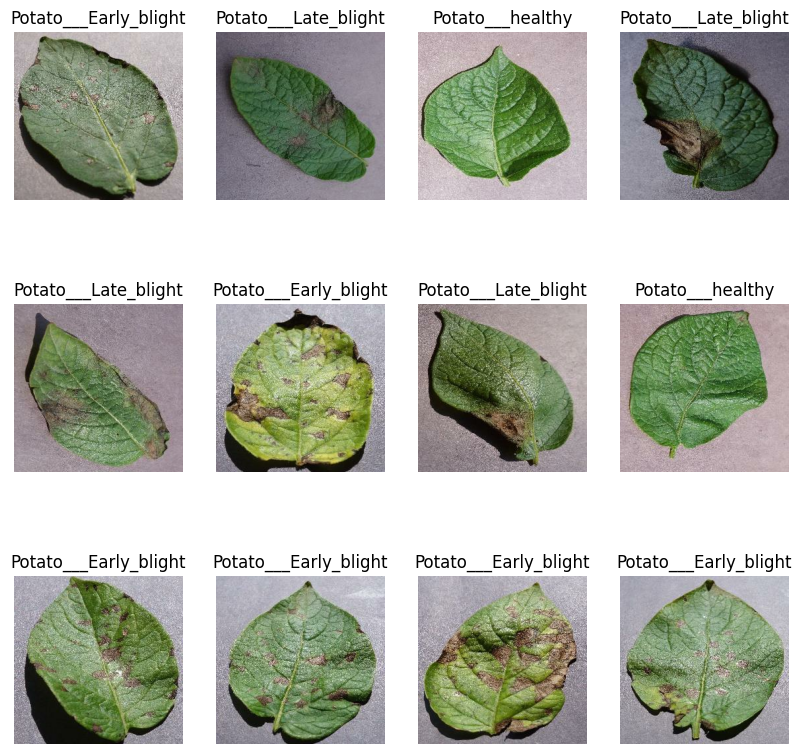

In [16]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(class_names[(label_batch[i])])
    plt.axis('off')


In [17]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [18]:
train_ds = dataset.take(54)

In [19]:
test_ds = dataset.skip(54)

In [20]:
# we need validastin and the test o...

In [21]:
val_size = 0.1
len(dataset)* val_size

6.800000000000001

In [22]:
val_ds = test_ds.take(6)

In [23]:
test_ds = test_ds.skip(6)

In [24]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split= 0.1, test_split= 0.1,shuffle = True, shuffle_size = 10000):

  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed = 12)

  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  tarin_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds

In [25]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [26]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [27]:
resized_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [28]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [29]:
# Make the models

In [30]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [31]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

# model.build(input_shape=input_shape)

In [32]:
model.build(input_shape=input_shape)

In [33]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [34]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [42]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
)

Epoch 1/30
54/54 [==============================] - 3s 59ms/step - loss: 2.9057e-05 - accuracy: 1.0000 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 2/30
54/54 [==============================] - 3s 60ms/step - loss: 2.6778e-05 - accuracy: 1.0000 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 3/30
54/54 [==============================] - 3s 60ms/step - loss: 2.3071e-05 - accuracy: 1.0000 - val_loss: 0.0037 - val_accuracy: 1.0000
Epoch 4/30
54/54 [==============================] - 3s 59ms/step - loss: 2.1181e-05 - accuracy: 1.0000 - val_loss: 0.0035 - val_accuracy: 1.0000
Epoch 5/30
54/54 [==============================] - 3s 59ms/step - loss: 1.9437e-05 - accuracy: 1.0000 - val_loss: 0.0035 - val_accuracy: 1.0000
Epoch 6/30
54/54 [==============================] - 3s 60ms/step - loss: 1.8068e-05 - accuracy: 1.0000 - val_loss: 0.0040 - val_accuracy: 1.0000
Epoch 7/30
54/54 [==============================] - 4s 65ms/step - loss: 1.5485e-05 - accuracy: 1.0000 - val_loss: 0.0043 - val_ac

In [44]:
scores = model.evaluate(test_ds)
scores

8/8 [==============================] - 0s 28ms/step - loss: 0.0019 - accuracy: 1.0000


[0.0018763556145131588, 1.0]

In [45]:
history.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

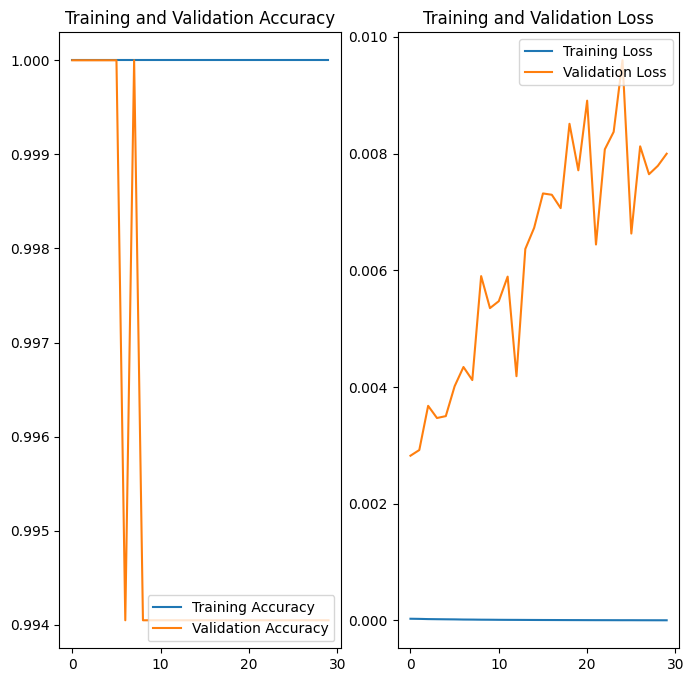

In [47]:
# Change the EPOCHS!!!!!
EPOCHS = 30
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [48]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 20ms/step


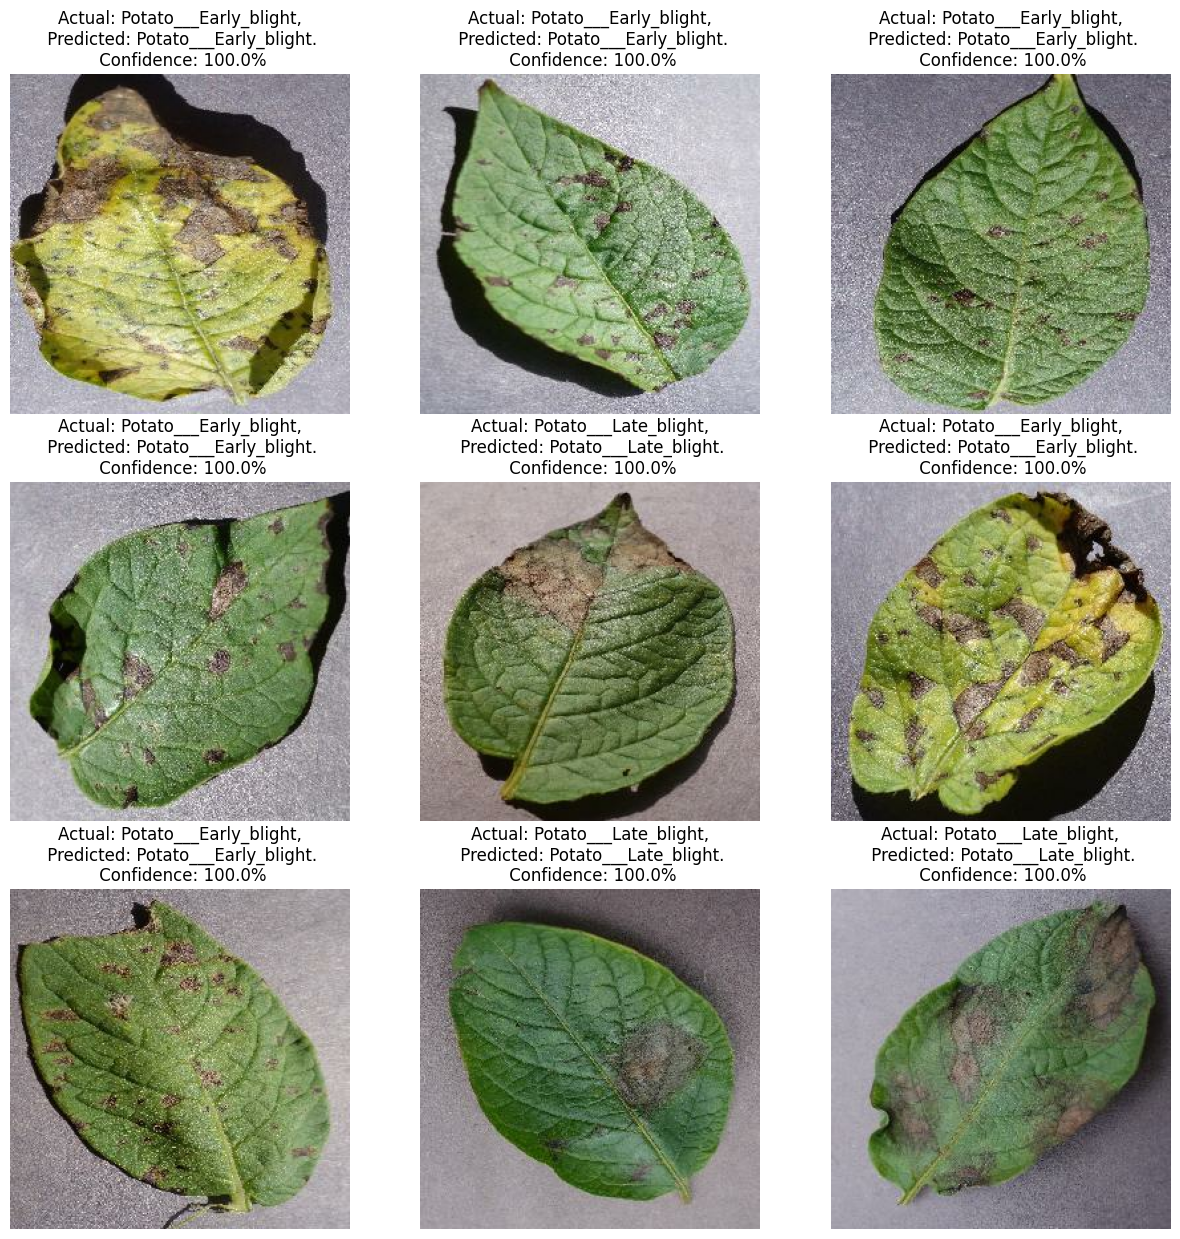

In [51]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [55]:
#model.save("../potatoes1")
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")